<a href="https://colab.research.google.com/github/guillaumetougas/sbl_hyperspectral_ai/blob/main/02_scripts/sbl_hyperspec_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D-CNN model from hyperspectral data


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torchvision as tv
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchaudio as ta
!pip install rasterio
import rasterio as rio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 89.5 MB/s eta 0:00:00


###Load preprocessed HS data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#Load HS data with geopandas
smoothed_data=gpd.read_file("/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/sbl_smoothed_spectra.gpkg")

#isolate spectral data and prepare with rasterio
spectral_data_labeled = smoothed_data.drop(columns=['geometry']).values
#print(np.shape(spectral_data_labeled))
#print(spectral_data_labeled[:5])

spectral_data = spectral_data_labeled[:, 1:243]
print(spectral_data[:,241])

[0.06830659106593368 0.05044518727648489 0.0711628405797041 ...
 0.0002695426312816876 0.0002724091850176913 0.0]


### Create the 1D-CNN model

In [20]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Example hyperspectral data (N samples, C spectral bands)
# Replace this with your actual data
N, C = 21696, 242  # Example: 21696 pixels, 242 bands
#X = spectral_data
#Y = labels

# Normalization (recommended for pretrained generic models like 1D CNN)
spectral_data = (spectral_data - np.min(spectral_data)) / (np.max(spectral_data) - np.min(spectral_data))

# Ensure spectral_data has a numeric dtype before converting to tensor
spectral_data = spectral_data.astype(np.float32)  # or np.float64

labels = smoothed_data['Label']
print(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectral_data, labels, test_size=0.2, random_state=42)

# 1. Create train/val indices instead of directly splitting
dataset_size = len(spectral_data)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20% for validation
np.random.shuffle(indices)  # Shuffle indices randomly
train_indices, val_indices = indices[split:], indices[:split]

# 2. Separate data using the indices
X_train, X_val = spectral_data[train_indices], spectral_data[val_indices]
y_train, y_val = labels.iloc[train_indices], labels.iloc[val_indices]

# 3. Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# 4. Create PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_val = torch.tensor(y_train_encoded, dtype=torch.long), torch.tensor(y_val_encoded, dtype=torch.long)

# Define a 1D CNN for hyperspectral data classification
class HyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(HyperspectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        fc1_input_size = 128 * input_channels #output size of conv2 x number of bands
        self.fc1 = nn.Linear(fc1_input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = self.pool(x)

        # Check if x has 3 dimensions before accessing x.size(2)
        #if x.dim() == 3:
        fc1_input_size = x.size(1) * x.size(2)
        #else:
            # If x has only 2 dimensions, calculate fc1_input_size accordingly
        #    fc1_input_size = x.size(1)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Adjust fc1 input size to match the actual flattened size
        self.fc1 = nn.Linear(fc1_input_size, 256)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

0         BEPA
1         ACRU
2        Picea
3         ACSA
4         ABBA
         ...  
21691     THOC
21692     THOC
21693    Picea
21694    Picea
21695     Mort
Name: Label, Length: 21696, dtype: object


###Model parameters and optimizer and loss function set up





In [21]:
# Model parameters
input_channels = C
num_classes = len(torch.unique(y_train))  # Number of unique labels
# Reshape for 1D CNN - Assuming spectral bands are in rows
# Transpose to have samples in rows and spectral bands in columns
X_train = X_train.T
X_val = X_val.T

# Initialize the model, loss function, and optimizer
model = HyperspectralCNN(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


###Train the model

In [22]:
#Training loop (example)
num_epochs = 10  # You can adjust this
for epoch in range(num_epochs):

 # Since your sequence length is 1 (each sample is a spectral signature),
  # you need to add a dimension:
  X_train_reshaped = X_train.T[:, :, None] #add extra dimension to have a 3D tensor

  # Create a DataLoader to handle batching
  train_dataset = torch.utils.data.TensorDataset(X_train_reshaped, y_train)  # Transpose X_train back

  #Define batch size
  batch_size = 32

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  for batch_idx, (data, target) in enumerate(train_loader):
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, target)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch [1/10], Loss: 1.9847
Epoch [1/10], Loss: 2.0119
Epoch [1/10], Loss: 2.2297
Epoch [1/10], Loss: 1.7458
Epoch [1/10], Loss: 2.0299
Epoch [1/10], Loss: 2.2600
Epoch [1/10], Loss: 2.2297
Epoch [1/10], Loss: 2.1391
Epoch [1/10], Loss: 2.0109
Epoch [1/10], Loss: 2.2156
Epoch [1/10], Loss: 2.4725
Epoch [1/10], Loss: 1.9036
Epoch [1/10], Loss: 2.1395
Epoch [1/10], Loss: 2.3236
Epoch [1/10], Loss: 1.8323
Epoch [1/10], Loss: 2.1219
Epoch [1/10], Loss: 1.9927
Epoch [1/10], Loss: 1.9618
Epoch [1/10], Loss: 2.1012
Epoch [1/10], Loss: 2.3371
Epoch [1/10], Loss: 2.2782
Epoch [1/10], Loss: 2.3496
Epoch [1/10], Loss: 2.3920
Epoch [1/10], Loss: 2.5751
Epoch [1/10], Loss: 2.3358
Epoch [1/10], Loss: 2.4172
Epoch [1/10], Loss: 1.9345
Epoch [1/10], Loss: 2.5221
Epoch [1/10], Loss: 2.5817
Epoch [1/10], Loss: 2.4141
Epoch [1/10], Loss: 2.2838
Epoch [1/10], Loss: 2.0863
Epoch [1/10], Loss: 2.4004
Epoch [1/10], Loss: 2.3886
Epoc

###Evaluate the model

In [23]:
# Evaluate the model on a test dataset
model.eval()
with torch.no_grad():
   # Reshape the validation data to add an extra dimension for sequence length
    X_val_reshaped = X_val.T[:, :, None]

    # Create a DataLoader for the validation set
    val_dataset = torch.utils.data.TensorDataset(X_val_reshaped, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for evaluation

    total_correct = 0
    total_samples = 0

    for data, target in val_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.3114


###Visualize model performance

In [24]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

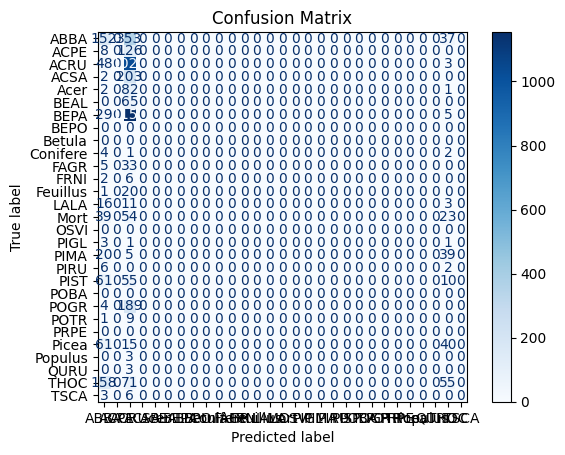

[ 152    0 1028    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   55
    0]


In [28]:
# Get predictions for the entire validation set
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

# Calculate confusion matrix
cm = confusion_matrix(y_val.cpu().numpy(), predicted.cpu().numpy(),labels=np.arange(len(label_encoder.classes_)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(np.diagonal(cm)) #Only ABBA, ACRU and THOC present TP